In [28]:
%matplotlib inline

import numpy as np
import random

from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Input, merge
from keras.optimizers import Adam
import keras.backend as K

import gym

from collections import deque
import heapq             #for priority queue
import sys

import matplotlib.pyplot as plt

INF = -sys.maxint

In [29]:
class priorityQueue(object):
    
    def __init__(self,maxlen = 2000):
        self.maxlen = maxlen
        self.Pqueue = []
    
    def push(self,element):
        heapq.heappush(self.Pqueue,element)
        if self.len() > self.maxlen:
            self.Pqueue.pop()
            heapq.heapify(self.Pqueue)
    
    def getBatch(self, batch_size):
        exp = [heapq.heappop(self.Pqueue) for i in range(batch_size)]
        return exp
    def len(self):
        return len(self.Pqueue)

In [30]:
class Agent(object):
    
    def __init__(self, state_size, action_size):
        
        self.state_size = state_size
        self.action_size = action_size
        self.memory = priorityQueue(2000)
        self.gamma = 0.95
        self.learning_rate = 0.001
        self.epsilon = 1.0  
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        self.count = 0
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
        
        
    def _loss(self, target, prediction):
        error = prediction - target
        return K.mean(K.sqrt(1+K.square(error))-1, axis=-1)
        
    def _build_model(self):

        inp_layer = Input(shape = (self.state_size,))
        
        net = Dense(64,activation='relu')(inp_layer)
        net = Dense(128, activation='relu')(net)
        net = Dense(128, activation='relu')(net)
        
        fc1 = Dense(64)(net)
        fc2 = Dense(64)(net)
        
        value = Dense(1)(fc1)
        advantage  = Dense(self.action_size)(fc2)
        
        policy = merge([advantage, value], mode = lambda x: x[0]-K.mean(x[0])+x[1],
                       output_shape = (self.action_size,))
        
        model = Model(inputs= [inp_layer], outputs= [policy] )
        model.compile(loss = self._loss, optimizer = Adam(lr=self.learning_rate))
        
        return model
    
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights() )
    
    def remember(self,state, action, reward, next_state, done,error =INF):
        self.memory.push( (error,self.count,state, action, reward, next_state, done) )
        self.count += 1
    
    def act(self, state):
        
#         if np.random.rand() <= self.epsilon:
#             return random.randrange(self.action_size)
        
        
        action_values = self.model.predict(state)[0]
        action = np.argmax(action_values)
        return action
    
    
    def PriorityReplay(self, batch_size):
        minibatch = self.memory.getBatch(batch_size)
        for _,_,state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state)
            
            if done:
                target[0][action] = reward
            else:
                a = self.model.predict(next_state)[0]
                t = self.target_model.predict(next_state)[0]
                target[0][action] = reward + self.gamma * t[np.argmax(a)]
           
            error =  abs(np.mean(self.model.predict(state) - target))
            self.remember(state,action,reward,next_state,done,-error)
            
            self.model.fit(state,target,epochs=1,verbose=0)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
    
    def load(self,floc):
        self.model.load_weights(floc)
    
    def save(self,floc):
        self.model.save_weights(floc)
        
        

In [31]:
env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.


In [32]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = Agent(state_size, action_size)
# agent.load('duel-dqn.h5')

/home/dhairya/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:38: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [33]:
done= False
batch_size = 32
episodes = 100

In [27]:
for e in range(episodes):
    state = env.reset()
    state = np.reshape(state, (1,state_size))
    for time in range(200):
#         env.render()
        action = agent.act(state)
        next_state,reward,done,_ = env.step(action)
        reward = reward if not done else -10
        
        next_state = np.reshape(next_state, (1,state_size))
        agent.remember(state, action, reward, next_state, done )
        state = next_state
        
        if done:
            agent.update_target_model()
            print "episode - {}, \t score - {}".format(e,time)
            break
            
        if agent.memory.len() > batch_size:
            agent.PriorityReplay(batch_size)

KeyboardInterrupt: 

In [34]:
agent.load('duel-dqn.h5')
state = env.reset()
score = []


for e in range(100):
    for time in range(200):
        state = np.reshape(state, (1,state_size))
        action  = agent.model.predict(state)[0]
        action = np.argmax(action)
        next_state,reward,done,_ = env.step(action)
        state = next_state
        if done:
            state = env.reset()
            score.append(time)
            break

In [35]:
print "mean score is {}".format(np.mean(score))

mean score is 148.845360825


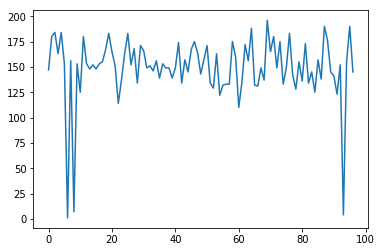

In [36]:
plt.plot(score)

In [ ]:
# agent.save('duel-dqn.h5')